# Классификация изображений

## Вступление
Сегодня мы перейдём чуть более сложным данным и архитектурам для классификации изображений.

### План семинара
1. Обучаем свёрточную сеть для задачи классификации изображений и смотрим на полученные фильтры свёрточных слоёв
2. Разбираемся с тем, что такое аугментации и зачем они нужны
3. Узнаём про способы регуляризации и нормализации при обучении нейронных сетей


In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Обучаем свёрточную сеть для задачи классификации изображений

Сегодня будем работать с датасетом [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000. Загрузим его аналогично тому, как мы загружали MNIST на предыдущих занятиях.

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True, num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False, num_workers=4
)

In [6]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5654321].


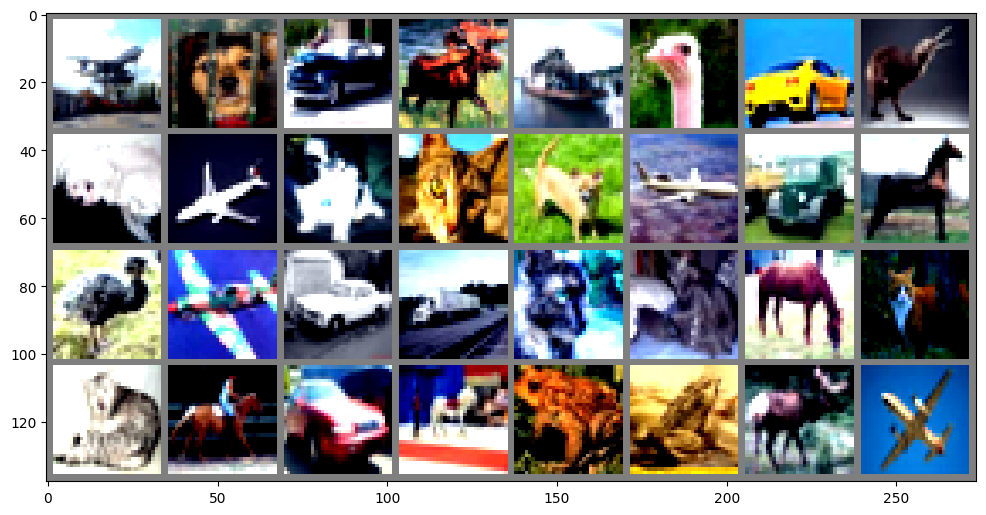

In [7]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [8]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

### Задание
В качестве бейзлайна постройте следующую архитектуру из 1 VGG блока:

1) VGG блок с 16 каналами:
* свёрточный слой с 16 выходными каналами и ядром 3x3, паддингом и нелинейностью ReLU
* свёрточный слой с 16 выходными каналами и ядром 3x3, паддингом и нелинейностью ReLU
* Max pooling c ядром 2x2 и шагом 2

2) Полносвязный слой с 128 выходами и нелинейностью ReLU

3) Полносвязный слой с 10 выходами и Softmax

In [7]:
class ModelBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        # x: (batch_size, n_channels, height, width)
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(
            train_dataloader, desc=f"Training, epoch {epoch}", leave=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        )
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:",
            (
                train_epoch_true_hits.sum()
                / train_epoch_true_hits.size(0)
                / train_dataloader.batch_size
            ).item(),
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:",
            (
                val_epoch_true_hits.sum()
                / val_epoch_true_hits.size(0)
                / val_dataloader.batch_size
            ).item(),
        )

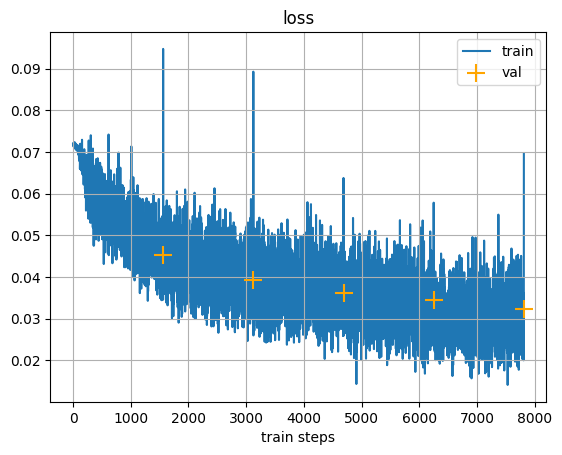

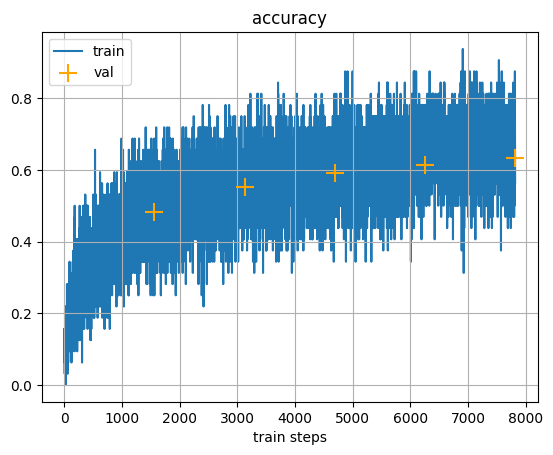

Train loss: 0.0302398931235075
Train acc: 0.6612483859062195
Val loss: 0.03238896653056145
Val acc: 0.6326876878738403


In [9]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader)

### Визуализируем параметры сети

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

def plot_filters_single_channel_big(t):

    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]


    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)

    npimg = npimg.T

    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)


def plot_filters_single_channel(t):

    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12

    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)

    count = 0
    fig = plt.figure(figsize=(ncols, nrows))

    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()


def plot_filters_multi_channel(t):

    #get the number of kernals
    num_kernels = t.shape[0]

    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels

    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))

    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)

        #for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.savefig('myimage.png', dpi=100)
    plt.tight_layout()
    plt.show()


def plot_filters(layer, single_channel = True, collated = False):
  #checking whether the layer is convolution layer or not
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data

    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)

    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")

  else:
    print("Can only visualize layers which are convolutional")


In [12]:
model_baseline.cpu()

ModelBaseline(
  (vgg): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

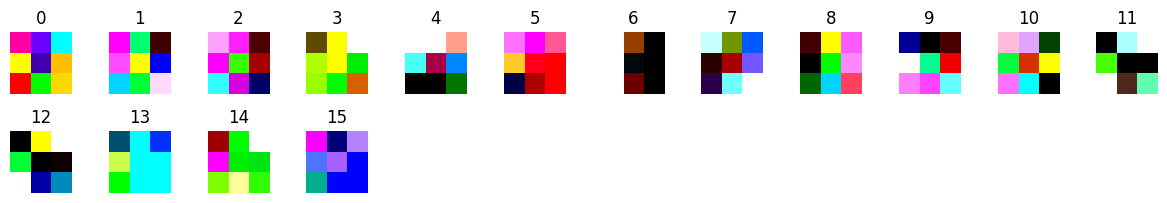

In [13]:
plot_filters(model_baseline.vgg[0], single_channel=False)

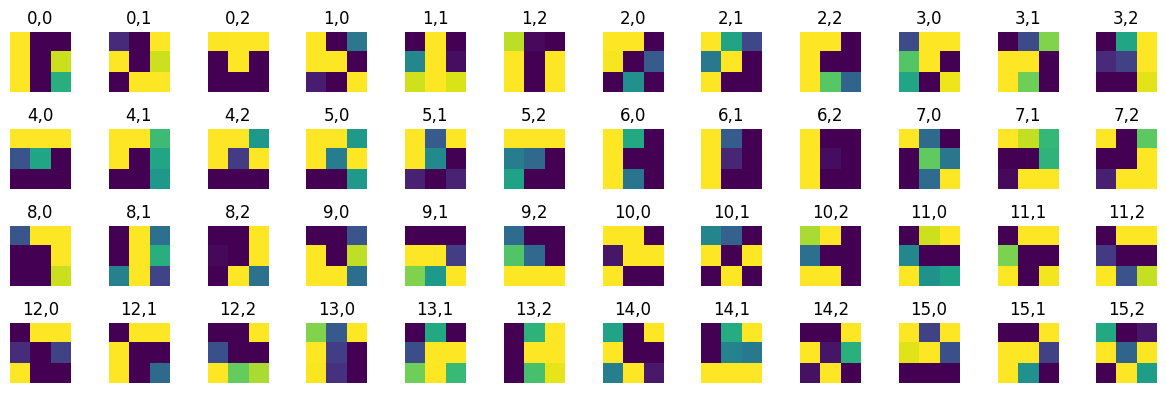

In [16]:
plot_filters(model_baseline.vgg[0], single_channel=True)

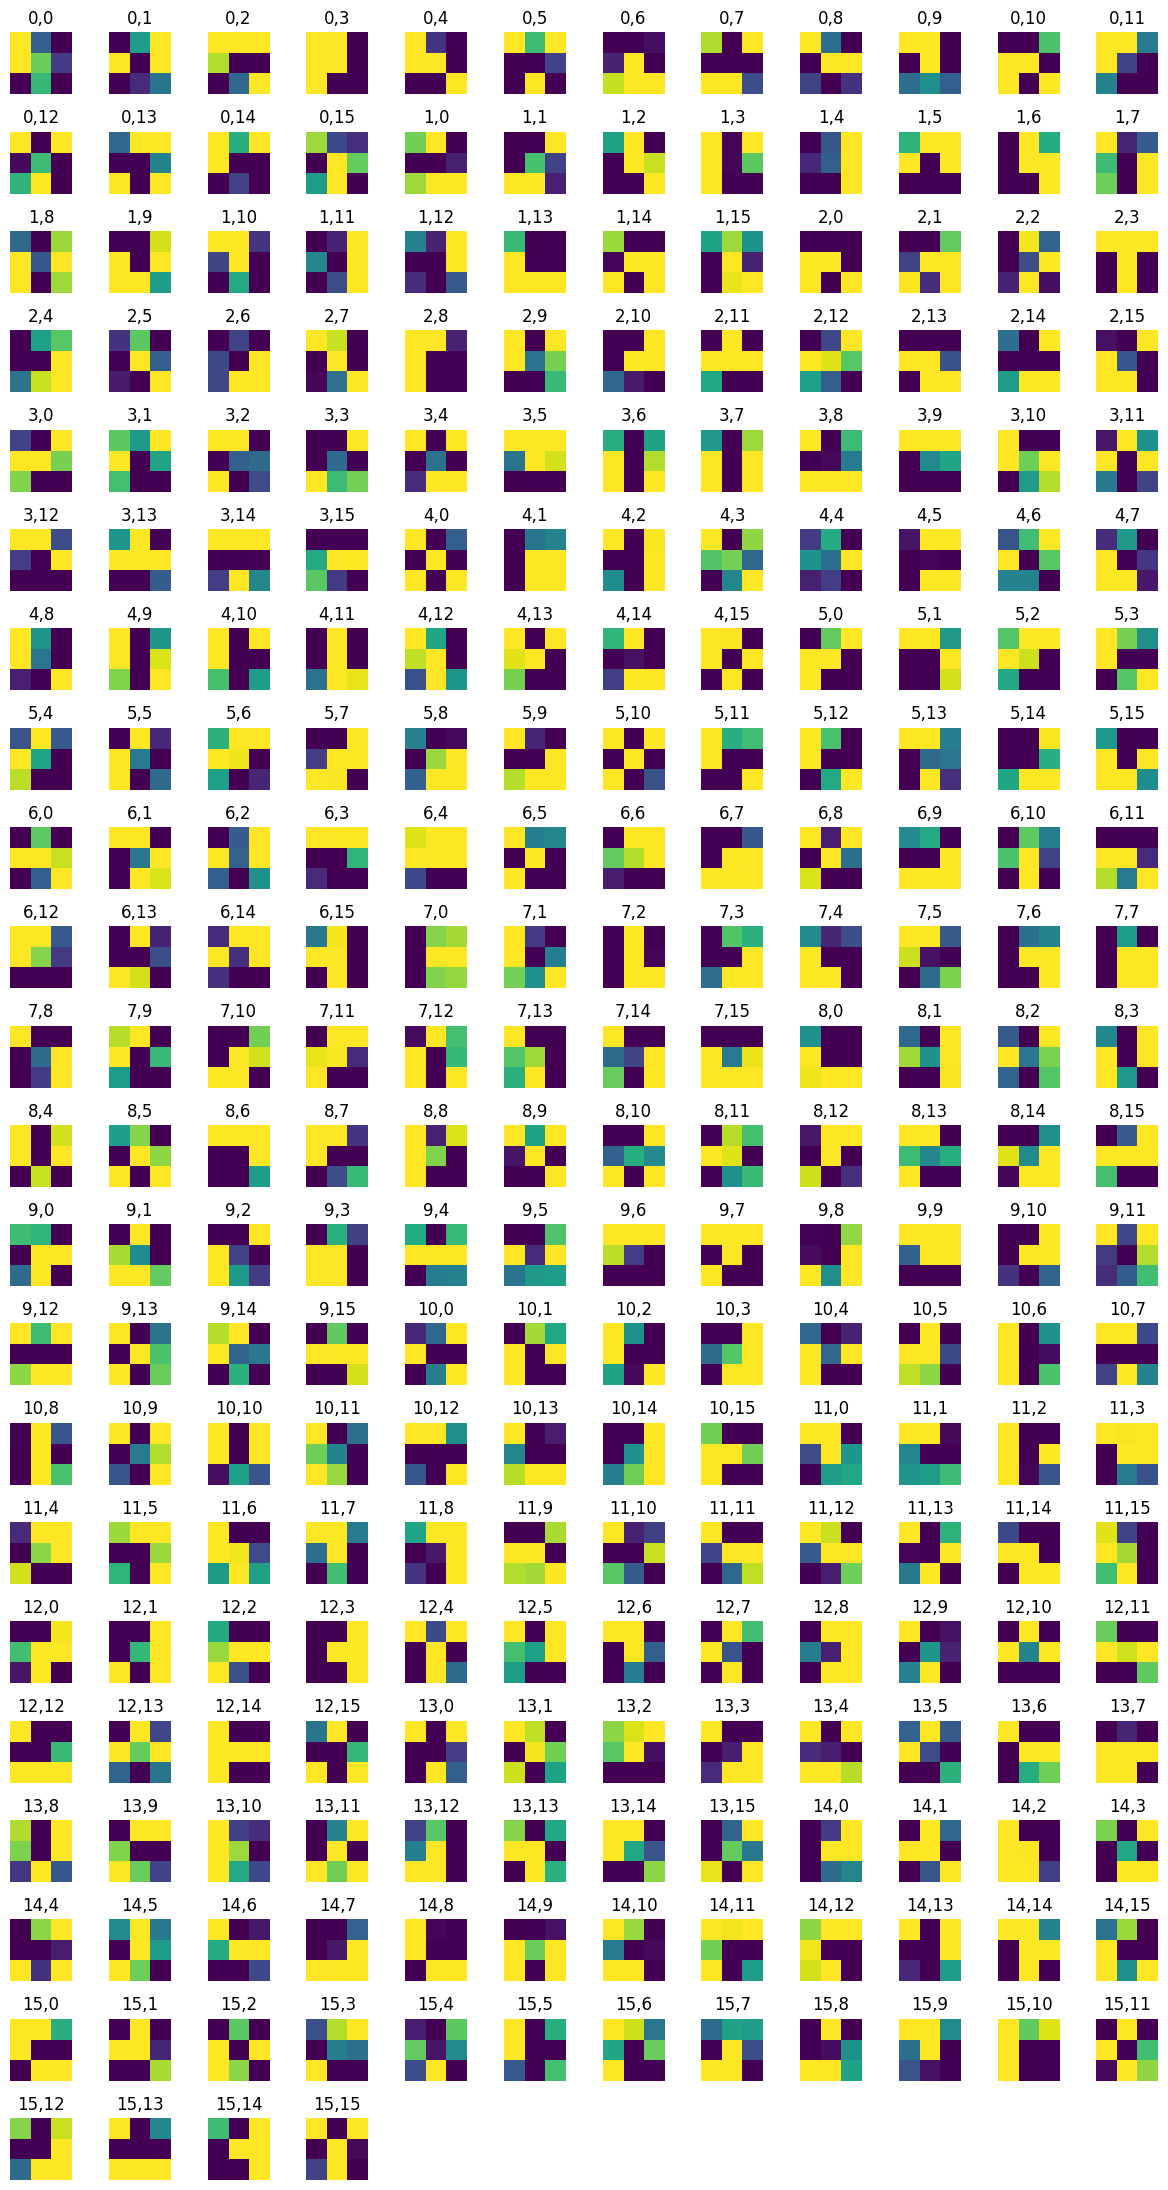

In [17]:
plot_filters(model_baseline.vgg[2], single_channel=True)

### Задание

Поэкспериментируйте с функциями активации сети. Попробуйте заменить ReLU на LeakyReLU, ELU или SELU. Как замена влияет на качество и скорость сходимости?

Почитать про разные функции активации можно [здесь](https://mlfromscratch.com/activation-functions-explained/#/).

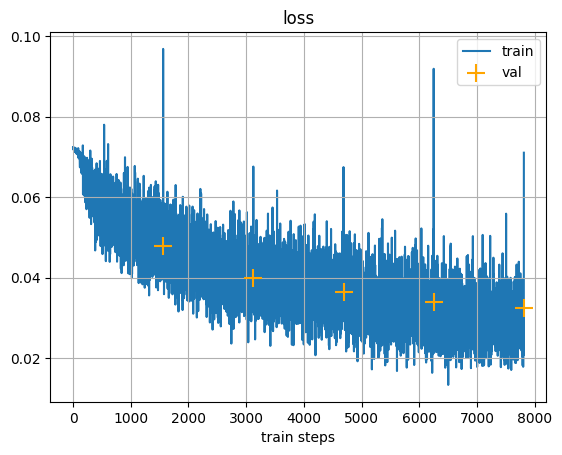

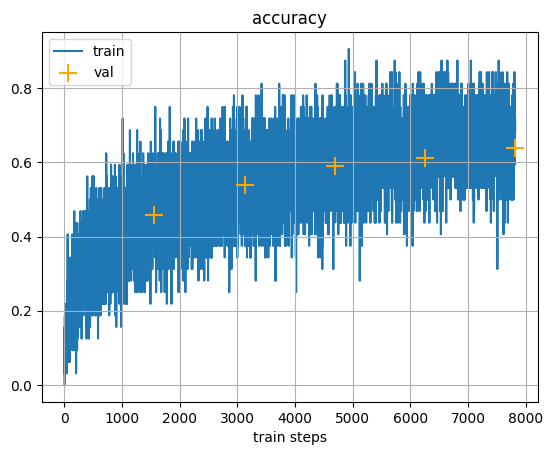

Train loss: 0.029819989576935768
Train acc: 0.663367748260498
Val loss: 0.03249169886112213
Val acc: 0.6379792094230652


In [19]:
class ModelBaseline(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            activation(),
            nn.Conv2d(16, 16, 3, padding=1),
            activation(),
            nn.MaxPool2d(2, stride=2),
        )
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.act = activation()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x


model_baseline2 = ModelBaseline(activation=nn.LeakyReLU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline2.parameters(), lr=0.001, momentum=0.9)

train(model_baseline2, criterion, optimizer, train_dataloader, val_dataloader)

C LeakyReLU работает немного лучше)

## 2. Аугментации

Аугментация данных - очень мощный процесс, который позволяет увеличить количество тренировочных данных. С помощью поворотов, отражения, добавления шума, сдвигов и других преобразований, картинка немного меняется, однако сохраняет свою прежнюю метку. С помощью функции Compose можно объединять несколько трансформаций изображения, а потом применять их при чтении датасета. Полный список аугментаций доступен [тут](https://pytorch.org/vision/stable/transforms.html). Изучите его и поэкспериментируйте с различными трансформациями изображения.

Довольно мощным и эффективным инструментом для аугментаций на картинках является библиотека `albumentations`. В этом курсе мы не будем её рассматривать, но можете поэкспериментировать с ней сами.

In [21]:
import PIL

transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=0.05, saturation=0.05), #
        '''Случайным образом изменяет цветовые параметры изображения — оттенок (hue)
        и насыщенность (saturation)'''
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

base_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(
    root="./cifar", train=True, download=True, transform=transform
)
cifar_val = torchvision.datasets.CIFAR10(
    root="./cifar", train=False, download=True, transform=base_transform
)

train_dataloader = torch.utils.data.DataLoader(
    cifar_train, batch_size=32, shuffle=True, num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    cifar_val, batch_size=32, shuffle=False, num_workers=4
)

Files already downloaded and verified
Files already downloaded and verified


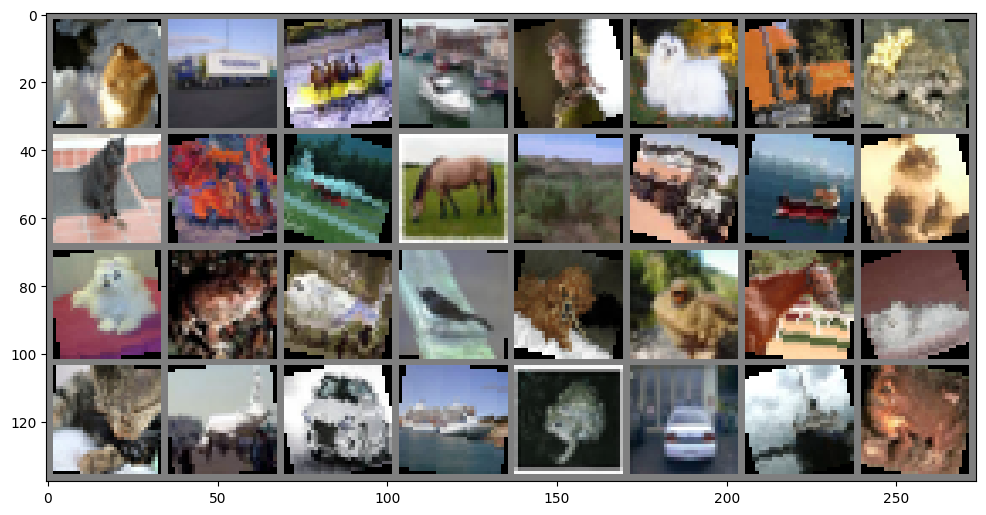

In [22]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12, 12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

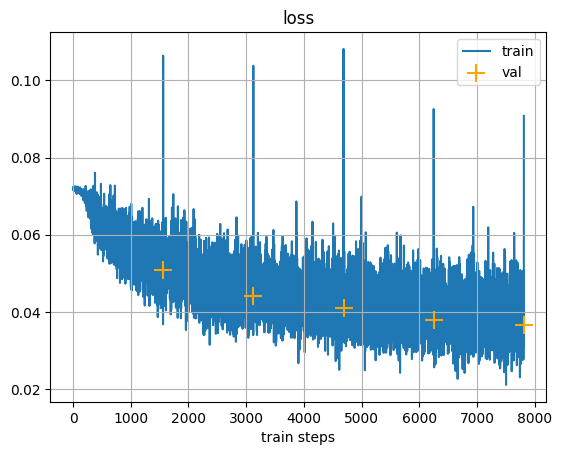

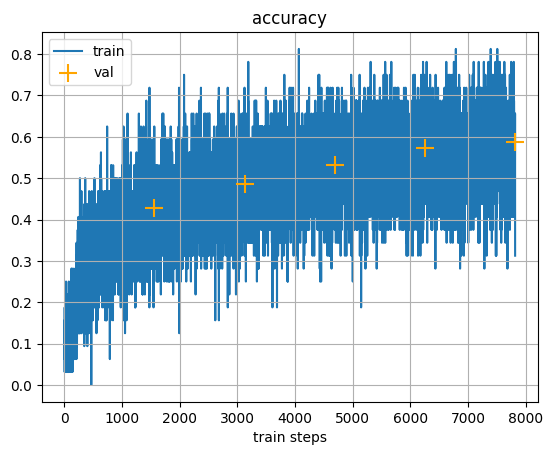

Train loss: 0.03892546147108078
Train acc: 0.5571017265319824
Val loss: 0.03656740486621857
Val acc: 0.5862619876861572


In [23]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader)

## 3. Регуляризации и нормализации в нейронных сетях

### Dropout
Если сеть имеет сложную архитектуру, то возможно переобучение - процесс, в котором модель слишком сильно подстраивается под тренировочную выборку и потом дает заниженное качество на тестовой. Для борьбы с этим можно использовать Dropout. Идея метода очень проста. На тренировке `torch.nn.Dropout` зануляет каждый элемент входного тензора с вероятностью $p$. На инференсе ничего не зануляется, но, для того, чтобы сохранить масштаб выходов сети, все элементы входного тензора делятся на $1 - p$.

![Dropout](dropout.png)

Для стабилизации и ускорения сходимости обучения часто используют батч нормализацию. В **PyTorch** она тоже имплементирована в виде слоя — [`torch.nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Обычно батч нормализацию вставляют между смысловыми блоками нейронной сети, чтобы сохранять распределение данных на всём forward pass. Обратите внимание, что на тренировке выборочные среднее и стандартное отклонение каждый раз заново вычисляются по батчу, а также у слоя есть обучаемых два числовых параметра на каждый канал входного тензора. На инференсе в качестве среднего и дисперсии используются оценки, полученные скользящими средними во время тренировки.

![Batch Norm](batch_norm.png)

Давайте обучим новую сеть, в которой будет 3 VGG блока и добавим в неё батч нормализацию и дропаут.

In [24]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),
    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
)

In [25]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

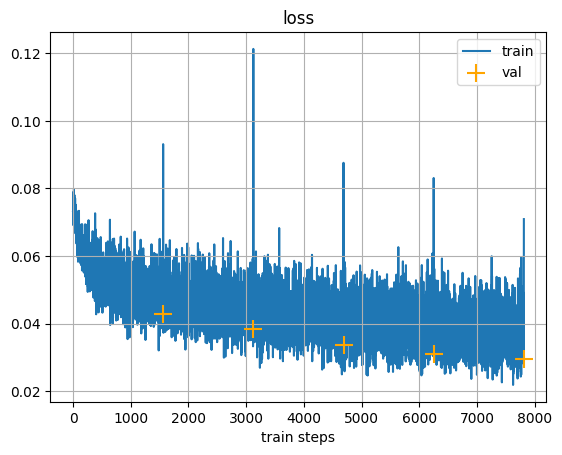

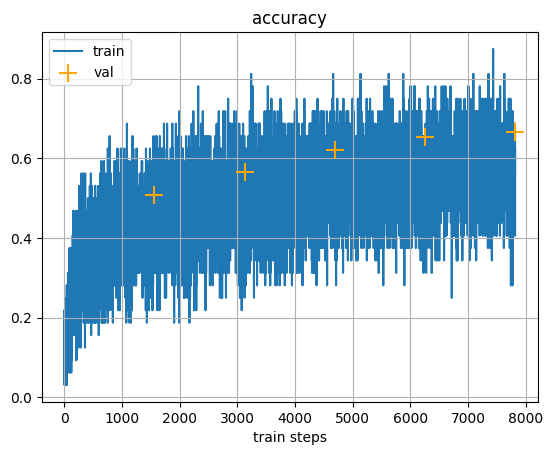

Train loss: 0.037819795310497284
Train acc: 0.5721569061279297
Val loss: 0.029641151428222656
Val acc: 0.6671326160430908


In [26]:
train(model, criterion, optimizer, train_dataloader, val_dataloader)